In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance
import preprof               ## my functions!

# BOW XGB
## imports & setup

In [12]:
bow_matrix=pickle.load(open('bow_matrix', 'rb'))

csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
papers=pd.read_csv(csv)
y = papers.loc[:,'category']

bow_nofeats=pickle.load(open('bow_nofeats','rb'))
bow_nofeats=pd.DataFrame(bow_nofeats.toarray())

x_train,x_test,y_train,y_test=train_test_split(bow_nofeats,y,test_size=0.15,random_state=61097,stratify=y)

In [4]:
preprof.print_proportions(y_train,y_test)

TRAINING
 Not relevant    63.789869
Relevant        36.210131
Name: category, dtype: float64

TESTING
 Not relevant    63.60424
Relevant        36.39576
Name: category, dtype: float64


In [6]:
model=XGBClassifier().fit(x_train,y_train)

## feature importance plotting & identification

In [ ]:
ax = plot_importance(model)
fig = ax.figure
#plt.savefig('bow_featimp.png')

In [ ]:
## nparray of numerical importances, with dropped weird column
feat_importance=np.array(list(model.feature_importances_[0:48])+list(model.feature_importances_[49:]))

## list of feature names in order
feature_names=list(bow_matrix)

In [ ]:
##returns index values for the num_feats highest values

def max_ind(array,num_feats):
    return list(array.argsort()[-num_feats:][::-1])

In [ ]:
## prints top n features
def top_n_feats(feature_names,feat_importance,n):
    top = []
    for x in max_ind(feat_importance,n):
        top.append(feature_names[x])
    return top

In [ ]:
topfeats=top_n_feats(feature_names,feat_importance,20)
for x in topfeats:
    print(x)

In [ ]:
data=pd.Series(feat_importance, index=feature_names).nlargest(20)
fig=data.plot(kind='barh',figsize=(10,8))
fig.figure.savefig('top28_bow.png')

## feature selection

In [ ]:
thresholds = sorted(list(np.unique(model.feature_importances_)))

In [14]:
thresh_acc={}

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_x_train, y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    thresh_acc[thresh]=accuracy
    print("Thresh=%.5f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

Thresh=0.00000, n=42056, Accuracy: 91.17%
Thresh=0.00174, n=165, Accuracy: 91.17%
Thresh=0.00348, n=109, Accuracy: 91.52%
Thresh=0.00523, n=71, Accuracy: 90.46%
Thresh=0.00697, n=55, Accuracy: 91.52%
Thresh=0.00871, n=39, Accuracy: 89.75%
Thresh=0.01045, n=32, Accuracy: 89.75%
Thresh=0.01220, n=24, Accuracy: 90.81%
Thresh=0.01394, n=15, Accuracy: 90.46%
Thresh=0.01568, n=14, Accuracy: 90.46%
Thresh=0.01742, n=11, Accuracy: 89.05%
Thresh=0.01916, n=8, Accuracy: 87.99%
Thresh=0.02091, n=7, Accuracy: 86.57%
Thresh=0.02265, n=6, Accuracy: 85.87%
Thresh=0.02613, n=3, Accuracy: 85.51%
Thresh=0.03310, n=2, Accuracy: 81.27%
Thresh=0.04007, n=1, Accuracy: 74.20%


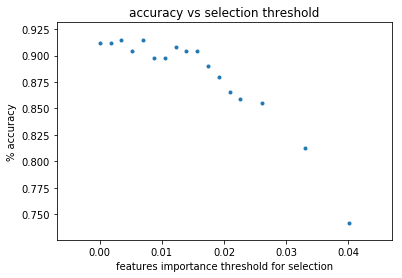

In [15]:
plt.scatter(thresh_acc.keys(),thresh_acc.values(),marker='.')
plt.ylabel('% accuracy')
plt.xlabel('features importance threshold for selection')
plt.title('accuracy vs selection threshold')
plt.savefig('bow_thresh.png')
plt.show()

so we can use a threshold of 0.007 where n=55 as this achieves greater accuracy than using all 42k features!!<br>
This minimises the amount of required computational power.

## evaluation of model w selected features

In [13]:
selection = SelectFromModel(model, threshold=0.006968641, prefit=True)
select_x_train = selection.transform(x_train)
select_x_test = selection.transform(x_test)
select_dataset = selection.transform(bow_nofeats)
select_dataset.shape

(1882, 55)

In [15]:
pickle.dump(select_dataset,open('selected_bow','wb'))

In [17]:
f_model = XGBClassifier().fit(select_x_train,y_train)
fy_pred=f_model.predict(select_x_test)
print('acc: {}'.format(accuracy_score(y_test,fy_pred)))
print('f1: {}'.format(f1_score(y_test,fy_pred,pos_label='Relevant')))
print(classification_report(y_test,fy_pred))

acc: 0.9151943462897526
f1: 0.8823529411764707
              precision    recall  f1-score   support

Not relevant       0.93      0.94      0.93       180
    Relevant       0.89      0.87      0.88       103

   micro avg       0.92      0.92      0.92       283
   macro avg       0.91      0.91      0.91       283
weighted avg       0.91      0.92      0.92       283



<br><br><br><br><br><br><br><br><br><br>

# TFIDF XGB
## imports & setup

In [16]:
tfidf_matrix=pickle.load(open('tfidf_matrix', 'rb'))

csv = '/Users/cdw/Desktop/pkpd_script/RNR_ANALYSIS/ready_processed.csv'
papers=pd.read_csv(csv)
y = papers.loc[:,'category']

tfidf_nofeats=pickle.load(open('tfidf_nofeats','rb'))
tfidf_nofeats=pd.DataFrame(tfidf_nofeats.toarray())

x_train,x_test,y_train,y_test=train_test_split(tfidf_nofeats,y,test_size=0.15,random_state=61097,stratify=y)

In [29]:
preprof.print_proportions(y_train,y_test)

TRAINING
 Not relevant    63.789869
Relevant        36.210131
Name: category, dtype: float64

TESTING
 Not relevant    63.60424
Relevant        36.39576
Name: category, dtype: float64


In [17]:
model=XGBClassifier().fit(x_train,y_train)

## feature importance plotting & identification

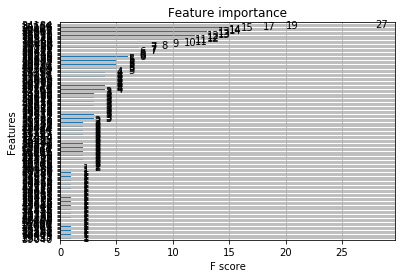

In [31]:
ax = plot_importance(model)
fig = ax.figure
#plt.savefig('tfidf_featimp.png')

In [32]:
## nparray of numerical importances, with dropped weird column
feat_importance=np.array(list(model.feature_importances_[0:48])+list(model.feature_importances_[49:]))

## list of feature names in order
feature_names=list(tfidf_matrix)

In [33]:
##returns index values for the num_feats highest values

def max_ind(array,num_feats):
    return list(array.argsort()[-num_feats:][::-1])

In [34]:
## prints top n features
def top_n_feats(feature_names,feat_importance,n):
    top = []
    for x in max_ind(feat_importance,n):
        top.append(feature_names[x])
    return top

In [35]:
top_20=top_n_feats(feature_names,feat_importance,20)
for x in top_20:
    print(x)

pharmacokinet
plasma
adultM
concentr
clearanc
pharmacokineticsT
oral
disposit
half-lif
review
model
drug
auc
animalsM
mg/kg
specif
femaleM
maleM
perform
area under curveM


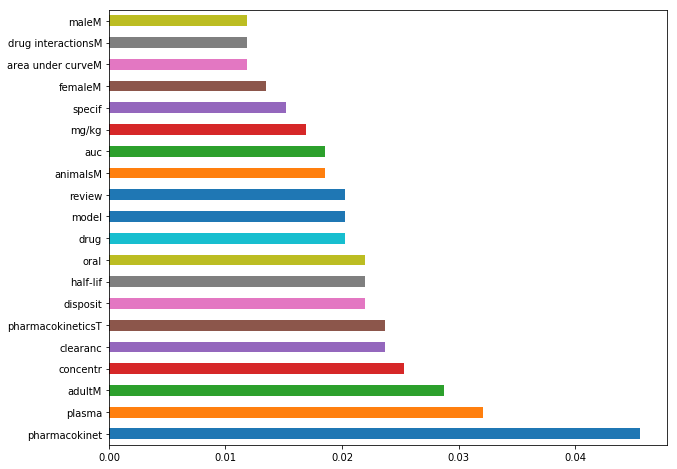

In [36]:
data=pd.Series(feat_importance, index=feature_names).nlargest(20)
fig=data.plot(kind='barh',figsize=(10,8))
fig.figure.savefig('top20_tfidf.png')

## feature selection

In [37]:
thresholds = sorted(list(np.unique(model.feature_importances_)))

In [38]:
thresh_acc={}

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    # train model
    selection_model = XGBClassifier().set_params(**params_tfidf)
    selection_model.fit(select_x_train, y_train)
    # eval model
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    thresh_acc[thresh]=accuracy
    print("Thresh=%.5f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

Thresh=0.00000, n=42056, Accuracy: 91.87%
Thresh=0.00169, n=164, Accuracy: 91.87%
Thresh=0.00338, n=110, Accuracy: 91.87%
Thresh=0.00507, n=73, Accuracy: 91.17%
Thresh=0.00676, n=51, Accuracy: 92.58%
Thresh=0.00845, n=36, Accuracy: 92.23%
Thresh=0.01014, n=26, Accuracy: 90.81%
Thresh=0.01182, n=21, Accuracy: 92.23%
Thresh=0.01351, n=17, Accuracy: 90.81%
Thresh=0.01520, n=16, Accuracy: 92.23%
Thresh=0.01689, n=15, Accuracy: 92.58%
Thresh=0.01858, n=14, Accuracy: 91.87%
Thresh=0.02027, n=12, Accuracy: 90.81%
Thresh=0.02196, n=9, Accuracy: 90.11%
Thresh=0.02365, n=6, Accuracy: 86.93%
Thresh=0.02534, n=4, Accuracy: 82.69%
Thresh=0.02872, n=3, Accuracy: 81.63%
Thresh=0.03209, n=2, Accuracy: 78.45%
Thresh=0.04561, n=1, Accuracy: 73.50%


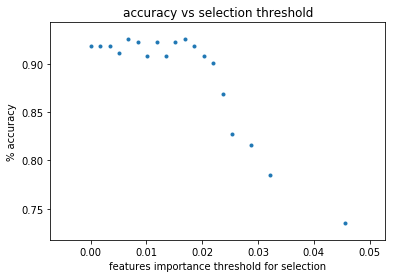

In [40]:
plt.scatter(thresh_acc.keys(),thresh_acc.values(),marker='.')
plt.ylabel('% accuracy')
plt.xlabel('features importance threshold for selection')
plt.title('accuracy vs selection threshold')
plt.savefig('tfidf_thresh.png')
plt.show()

so we can use a threshold of 0.005 where n=192 as this achieves almost the same accuracy as using all 42k features.<br>
There's a trade-off between the number computational power and accuracy but it's worth it.

## evaluation of model w selected features

In [18]:
selection = SelectFromModel(model, threshold=0.0067, prefit=True)
select_x_train = selection.transform(x_train)
select_x_test = selection.transform(x_test)
select_data=selection.transform(tfidf_nofeats)
select_x_train.shape

(1599, 51)

In [19]:
pickle.dump(select_data,open('selected_tfidf','wb'))

In [43]:
f_model = XGBClassifier().fit(select_x_train,y_train)
fy_pred=f_model.predict(select_x_test)
print(accuracy_score(y_test,fy_pred))
print(f1_score(y_test,fy_pred,pos_label='Relevant'))
print(classification_report(y_test,fy_pred))

0.9257950530035336
0.896551724137931
              precision    recall  f1-score   support

Not relevant       0.93      0.95      0.94       180
    Relevant       0.91      0.88      0.90       103

   micro avg       0.93      0.93      0.93       283
   macro avg       0.92      0.92      0.92       283
weighted avg       0.93      0.93      0.93       283

